# Generate cellxgene

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/'
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

# Prepare INPUT

## Load raw and annoted andata

In [2]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [3]:
adata = sc.read(path_to_gonads + 'FCA-gonads_rawcounts.h5ad')
adata.X.shape

(396565, 28820)

In [4]:
adata_annotated = sc.read(path_to_gonads+'/FCA-gonads_somatic_annotated.h5ad')
adata_annotated.X.shape

(194104, 25883)

### Import somatic annotation

In [5]:
cell_annot = adata_annotated.obs['celltype'].to_dict()
adata.obs['celltype'] = adata.obs_names.map(cell_annot)
adata.obs['celltype'].value_counts()

Sertoli                 36795
Ti                      34474
Oi                      25087
preGC_IIb               23813
preGC_I                 16430
preGC_IIa               13547
OSE                      8126
CoelEpi_LHX9             6436
early_supporting         4674
early_sPAX8              4280
CoelEpi_GATA2            4205
Gi                       3567
FetalLeydig              2873
early_somatic            2830
cont                     2636
late_sPAX8               2114
CoelEpi_LHX9_cycling     1613
granulosa                 366
lowQC                     238
Name: celltype, dtype: int64

In [6]:
cell_annot = adata_annotated.obs['lineage'].to_dict()
adata.obs['lineage'] = adata.obs_names.map(cell_annot)
adata.obs['lineage'].value_counts()

Mesenchymal_LHX9    65978
preGranulosa        38876
Sertoli             34969
Supporting          27931
CoelEpi             23924
FetalLeydig          2426
Name: lineage, dtype: int64

## Remove lowQC cells and artifacts

In [7]:
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.lineage]]
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.celltype]]
adata = adata[[not pd.isna(i) for i in adata.obs.celltype]]

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 191230
Total number of genes: 28820


## Import UMAP

In [9]:
adata_annotated = adata_annotated[[ i in adata.obs_names for i in adata_annotated.obs_names ]]

In [10]:
adata.obsm['X_umap'] = adata_annotated.obsm['X_umap']
adata.obsm['X_scVI'] = adata_annotated.obsm['X_scVI']
# adata.obsp['connectivities'] = adata_annotated.obsp['connectivities']
# adata.obsp['distances'] = adata_annotated.obsp['distances']
# adata.uns['celltype_colors'] = adata_annotated.uns['celltype_colors']
# adata.uns['neighbors'] = adata_annotated.uns['neighbors']

## Remove un necessary data

In [11]:
del adata_annotated

In [12]:
del adata.obs['study']
del adata.obs['stage']
del adata.obs['batch_collection']
del adata.obs['lineages_v1']
del adata.obs['celltype_v1']
del adata.obs['lineage_v2']
del adata.obs['somatic_celltype_v2']
del adata.obs['batch']

# Normalize data

In [13]:
adata.raw = adata.copy()

In [14]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)                                                                                                            
sc.pp.scale(adata, max_value=10)

... storing 'celltype' as categorical
... storing 'lineage' as categorical


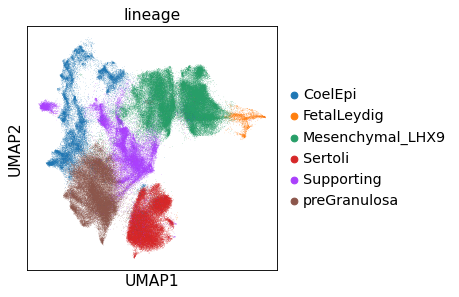

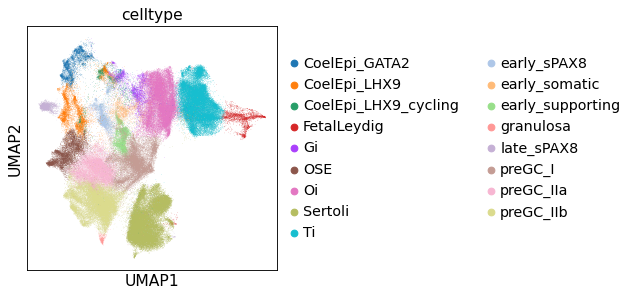

In [15]:
sc.pl.umap(adata, color='lineage')
sc.pl.umap(adata, color='celltype')

In [16]:
adata.write('/nfs/cellgeni/tickets/tic-613/human_somatic.h5ad')